In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # 10 values x 3 priors x 200 neur.
b1 = torch.randn(n_hidden,                        generator=g) # 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size),          generator=g) # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size,                      generator=g) # 27 output biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True

11897 parameters


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1          # Hidden layer pre-activation
    h = torch.tanh(hpreact)             # Hidden layer
    logits = h @ W2 + b2                # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        p.grad = None # Making sure that prior iteration's gradients are gone
    loss.backward()   # This calculates the current (new) gradients
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

/home/u229589/workspace/private/Andrej-Karpathy-Zero-To-Hero/.venv/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 103: integrity checks failed (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      0/ 200000: 27.8817
  10000/ 200000: 2.9417
  20000/ 200000: 2.5795
  30000/ 200000: 2.7819
  40000/ 200000: 2.0216
  50000/ 200000: 2.5858
  60000/ 200000: 2.3217
  70000/ 200000: 2.1007
  80000/ 200000: 2.2893
  90000/ 200000: 2.2368
 100000/ 200000: 1.9774
 110000/ 200000: 2.4507
 120000/ 200000: 1.9623
 130000/ 200000: 2.3657
 140000/ 200000: 2.2424
 150000/ 200000: 2.1469
 160000/ 200000: 2.2506
 170000/ 200000: 1.7543
 180000/ 200000: 2.1055
 190000/ 200000: 1.8174


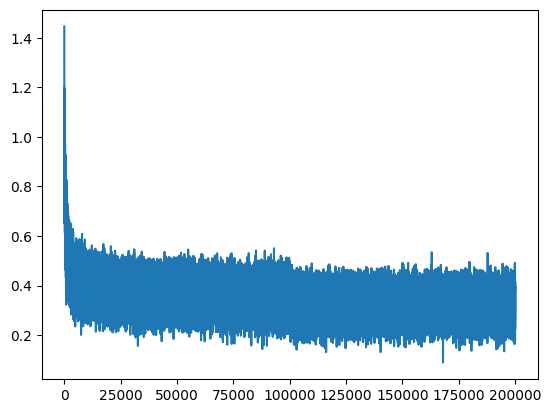

In [7]:
plt.plot(lossi)

In [8]:
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]    # That's a switch (never seen it like this!)
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.126697540283203
val 2.171041250228882


In [9]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # Forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # Shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # As soon as we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # Decode and print the generated word

mona.
mayah.
see.
mel.
ryllo.
emmadiengramira.
eredielin.
shy.
jen.
eden.
eson.
arleiyah.
hone.
cayshubergihimier.
kendreelynn.
nochorius.
macder.
yaque.
ehs.
kayjahsin.


### Problem 1: Unrealistically high initial loss

In [11]:
# loss should be arround:
-torch.tensor(1/27).log()

tensor(3.2958)

In [35]:
# toy problem to play with the loss
logits = torch.tensor([-8.0, 5.0, 1.0, 10.0])
logits = torch.tensor([1.0, 5.0, 1.0, 1.0])
probs = torch.softmax(logits, dim=0)
idx_correct_elem = 1
loss = -probs[idx_correct_elem].log()

logits, probs, loss

(tensor([1., 5., 1., 1.]),
 tensor([0.0174, 0.9479, 0.0174, 0.0174]),
 tensor(0.0535))

In [40]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # 10 values x 3 priors x 200 neur.
b1 = torch.randn(n_hidden,                        generator=g) # 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size,                      generator=g) * 0 # 27 output biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True

11897 parameters


In [41]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


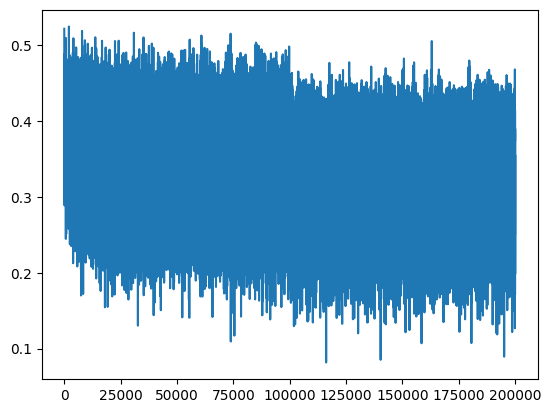

In [42]:
plt.plot(lossi)

In [43]:
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]    # That's a switch (never seen it like this!)
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310744285583496


### Problem2: Saturated Tanh

In [48]:
h.shape, h.view(-1).shape

(torch.Size([32, 200]), torch.Size([6400]))

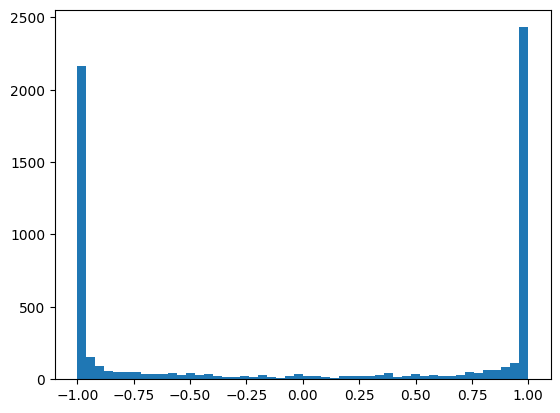

In [53]:
plt.hist(h.view(-1).tolist(), 50);

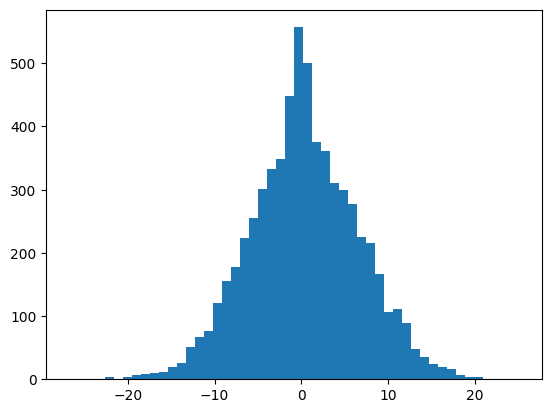

In [54]:
plt.hist(hpreact.view(-1).tolist(), 50);

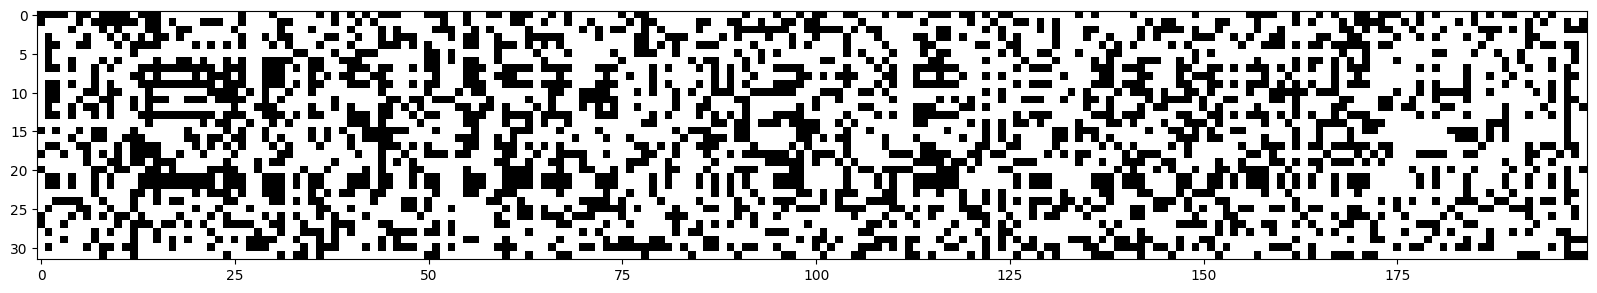

In [55]:
plt.figure(figsize=(20,100))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [64]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # 10 values x 3 priors x 200 neur.
b1 = torch.randn(n_hidden,                        generator=g) * 0.01# 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size,                      generator=g) * 0 # 27 output biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True

11897 parameters


In [57]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    break # run only the first batch

      0/ 200000: 3.3135


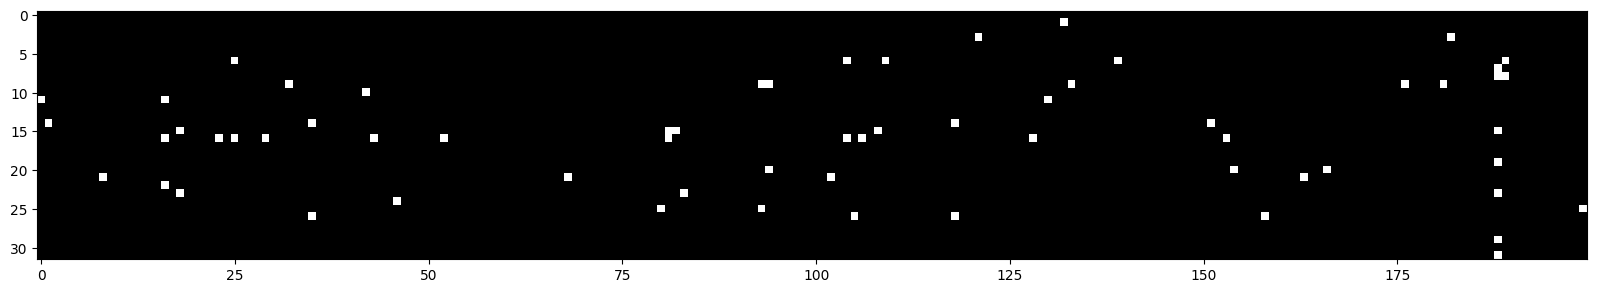

In [58]:
plt.figure(figsize=(20,100))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

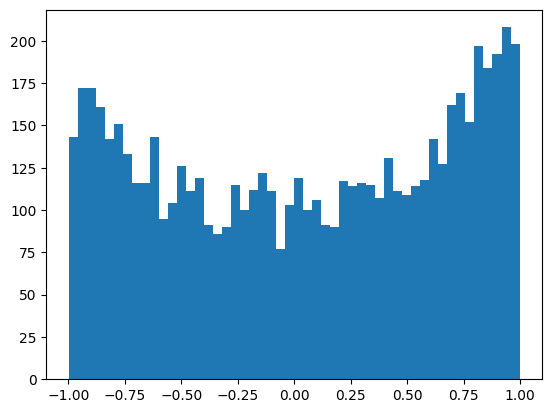

In [61]:
plt.hist(h.view(-1).tolist(), 50);

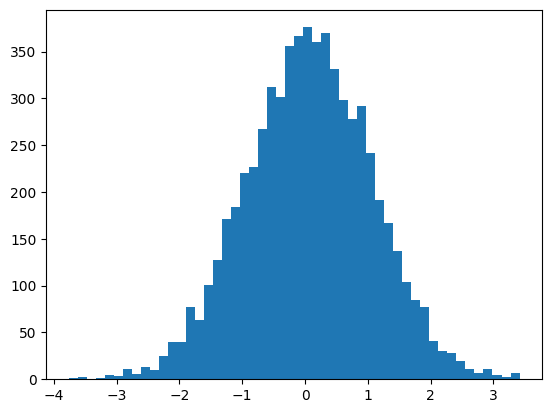

In [62]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [65]:
for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


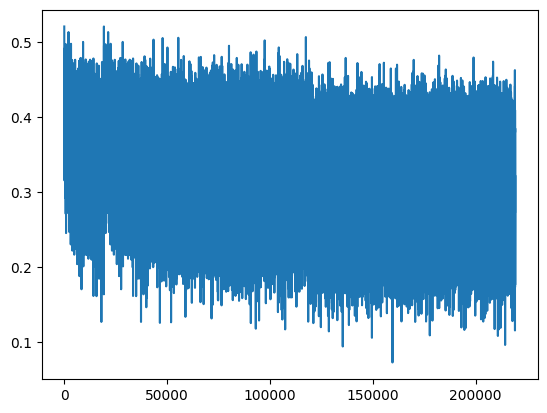

In [66]:
plt.plot(lossi)

In [67]:
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]    # That's a switch (never seen it like this!)
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355963706970215
val 2.1026782989501953


### Proper Initialization

In [68]:
x = torch.randn(1000, 10)
W = torch.randn(10, 200)
y = x @ W

print(f"x: ", x.mean(), x.std())
print(f"W: ", W.mean(), W.std())
print(f"y: ", y.mean(), y.std())

x:  tensor(-0.0161) tensor(0.9932)
W:  tensor(0.0279) tensor(1.0152)
y:  tensor(-0.0058) tensor(3.1870)


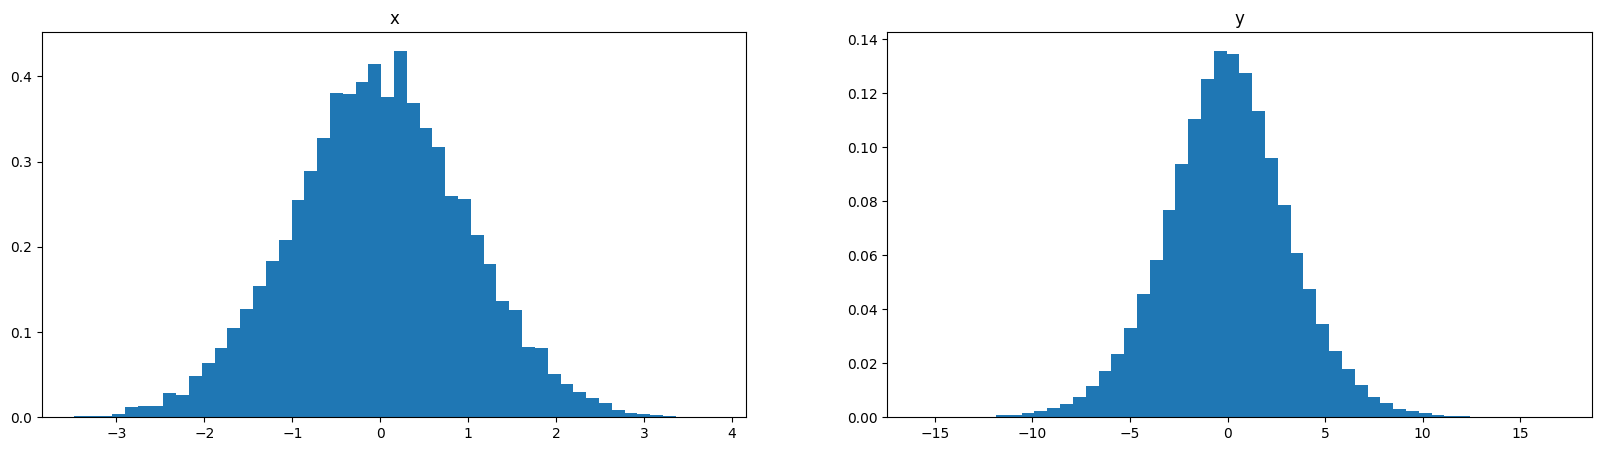

In [70]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.title("x")
plt.hist(x.view(-1).tolist(), 50, density=True);

plt.subplot(122)
plt.title("y")
plt.hist(y.view(-1).tolist(), 50, density=True);

In [71]:
x = torch.randn(1000, 10) 
W = torch.randn(10, 200) * 10 **-0.5 # 10 is the fan-in of that layer
y = x @ W

print(f"x: ", x.mean(), x.std())
print(f"W: ", W.mean(), W.std())
print(f"y: ", y.mean(), y.std())

x:  tensor(0.0046) tensor(1.0000)
W:  tensor(0.0045) tensor(0.3110)
y:  tensor(-0.0022) tensor(0.9841)


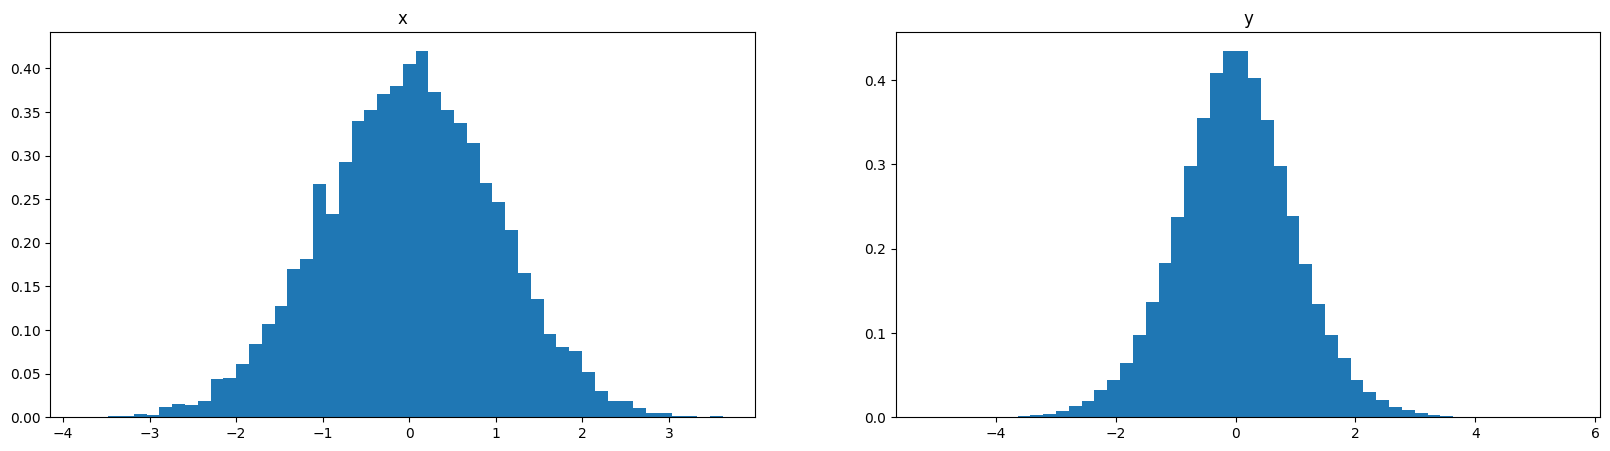

In [72]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.title("x")
plt.hist(x.view(-1).tolist(), 50, density=True);

plt.subplot(122)
plt.title("y")
plt.hist(y.view(-1).tolist(), 50, density=True);

In [73]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd*block_size)**0.5 # 10 values x 3 priors x 200 neur.
b1 = torch.randn(n_hidden,                        generator=g) * 0.01# 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size,                      generator=g) * 0 # 27 output biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True

11897 parameters


In [74]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9751
 190000/ 200000: 1.8614


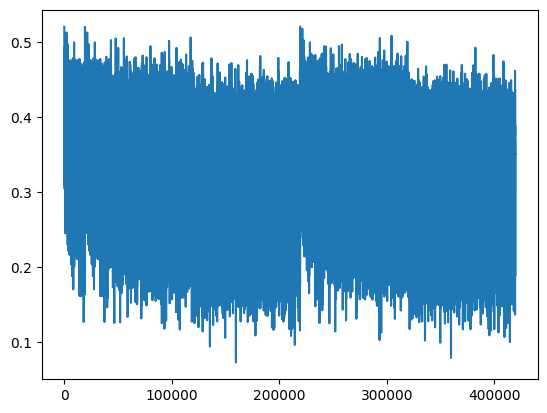

In [75]:
plt.plot(lossi)

In [76]:
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]    # That's a switch (never seen it like this!)
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376646518707275
val 2.106989622116089


In [79]:
?torch.nn.init.kaiming_normal_

Signature:
torch.nn.init.kaiming_normal_(
    tensor: torch.Tensor,
    a: float = 0,
    mode: str = 'fan_in',
    nonlinearity: str = 'leaky_relu',
)
Docstring:
Fills the input `Tensor` with values according to the method
described in `Delving deep into rectifiers: Surpassing human-level
performance on ImageNet classification` - He, K. et al. (2015), using a
normal distribution. The resulting tensor will have values sampled from
:math:`\mathcal{N}(0, \text{std}^2)` where

.. math::
    \text{std} = \frac{\text{gain}}{\sqrt{\text{fan\_mode}}}

Also known as He initialization.

Args:
    tensor: an n-dimensional `torch.Tensor`
    a: the negative slope of the rectifier used after this layer (only
        used with ``'leaky_relu'``)
    mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
        preserves the magnitude of the variance of the weights in the
        forward pass. Choosing ``'fan_out'`` preserves the magnitudes in the
        backwards pass.
    non

In [94]:
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
W1[:,0].mean(), W1[:,0].std()

(tensor(0.0906), tensor(1.0525))

In [95]:
torch.nn.init.kaiming_normal_(tensor=W1, nonlinearity="tanh")

tensor([[-0.1236, -0.1795,  0.1805,  ...,  0.0002,  0.1035,  0.0574],
        [ 0.1015,  0.0897,  0.0401,  ...,  0.1544, -0.0317,  0.0900],
        [ 0.0419,  0.0444,  0.0702,  ...,  0.0416, -0.0905, -0.0253],
        ...,
        [-0.0367,  0.0422,  0.0336,  ..., -0.0009,  0.0513,  0.1781],
        [-0.1631,  0.1728, -0.0249,  ...,  0.0918,  0.0597, -0.0090],
        [-0.0734,  0.0119,  0.0610,  ..., -0.0145, -0.0068, -0.1653]])

In [97]:
W1[:,0].mean(), W1[:,0].std()

(tensor(0.0061), tensor(0.0833))

### Batch Normalization

In [90]:
hpreact.shape

torch.Size([32, 200])

In [93]:
# mean along batch
hpreact.mean(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [98]:
# std along batch
hpreact.std(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [99]:
hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)

In [101]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd*block_size)**0.5 # 10 values x 3 priors x 200 neur.
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01# 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size,                      generator=g) * 0 # 27 output biases

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True

12097 parameters


In [102]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 # + b1

    hpreact_mean = hpreact.mean(dim=0, keepdim=True)
    hpreact_std = hpreact.mean(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - hpreact_mean) / hpreact_std + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * hpreact_mean
        bnstd_running = 0.999 * bnstd_running + 0.001 * hpreact_std

    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.2838
  10000/ 200000: 2.1490
  20000/ 200000: 2.5686
  30000/ 200000: 2.0146
  40000/ 200000: 2.4305
  50000/ 200000: 1.7537
  60000/ 200000: 2.1518
  70000/ 200000: 2.3900
  80000/ 200000: 2.3305
  90000/ 200000: 2.1420
 100000/ 200000: 2.1879
 110000/ 200000: 2.3528
 120000/ 200000: 1.5966
 130000/ 200000: 1.9024
 140000/ 200000: 2.3147
 150000/ 200000: 1.9515
 160000/ 200000: 2.0531
 170000/ 200000: 2.3891
 180000/ 200000: 2.0487
 190000/ 200000: 2.1554


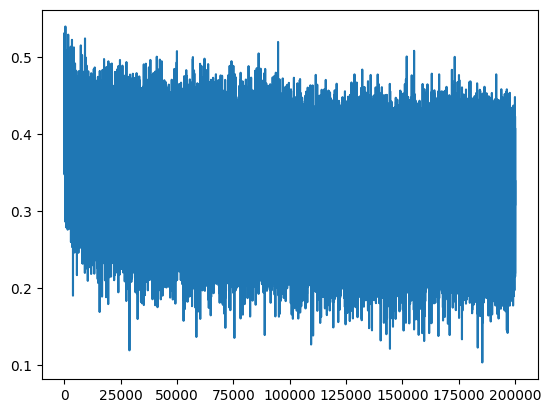

In [103]:
plt.plot(lossi)

In [104]:
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]    # That's a switch (never seen it like this!)
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)

    hpreact = embcat @ W1 + b1
    hpreact = bngain * ((hpreact-bnmean_running) / bnstd_running) + bnbias
    
    h = torch.tanh(hpreact)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0810861587524414
val 2.1211979389190674


### Pytorchifying

In [105]:
lin = torch.nn.Linear(10*3, 200)
x = torch.randn(100, 10*3)
y = lin(x)
y.shape

torch.Size([100, 200])

In [108]:
class Linear: 
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self) -> list[torch.Tensor]:
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [110]:
class BatchNorm1d:

    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return [self.gamma, self.beta]

In [111]:
class Tanh:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self) -> list[torch.Tensor]:
        return []

In [195]:
def create_model(gain: float = 5/3):
    n_embd = 10
    n_hidden = 100
    g = torch.Generator().manual_seed(2147483647)

    C = torch.randn((vocab_size, n_embd), generator=g)

    layers = [
        Linear(n_embd * block_size, n_hidden), Tanh(),
        Linear(           n_hidden, n_hidden), Tanh(),
        Linear(           n_hidden, n_hidden), Tanh(),
        Linear(           n_hidden, n_hidden), Tanh(),
        Linear(           n_hidden, n_hidden), Tanh(),
        Linear(           n_hidden, vocab_size),
    ]

    with torch.no_grad():
        layers[-1].weight *= 0.1
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= gain

    parameters = [C] + [p for layer in layers for p in layer.parameters()]
    print(sum(p.nelement() for p in parameters))

    for p in parameters:
        p.requires_grad = True
    
    return C, layers, parameters

In [136]:
C, layers, parameters = create_model()

46497


In [181]:
def train_model_with_brake(C, layers, parameters, break_after_iteration=None):
    # Same optimization as last time
    max_steps = 200000
    batch_size = 32
    lossi = []
    ud = []            # Keeping track of Update-to-Data ratio

    for i in range(max_steps):
        
        # Minibatch-Construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y

        # forward pass
        emb = C[Xb]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb)

        # backward pass
        for layer in layers:
            layer.out.retain_grad()
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad
            
        # Tracking stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
            lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

        if break_after_iteration:
            if i >= break_after_iteration:
                break # Take this out to run full optimization/training
    return ud

In [167]:
train_model_with_brake(C, layers, parameters, 1)

      0/ 200000: 3.2836


In [168]:
def visualize_activations_or_gradients(layers, show_activations: bool = True):
    # Visualize histograms (forward pass activations) for the Tanh layers
    # (below is what it looks like when Batch-Normalization is needed)
    # We can see how many tensor values take on which x-axis values
    plt.figure(figsize=(20, 4)) # Width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer, these are all Tanh layers
        if isinstance(layer, Tanh):
            if show_activations:
                t = layer.out
            else:
                t = layer.out.grad
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'Layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
    if show_activations:
        plt.title('Activation Distribution')
    else:
        plt.title('Gradient Distribution')

layer 1 (      Tanh): mean +0.01, std 0.40, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.19, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.10, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.05, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.03, saturated: 0.00%


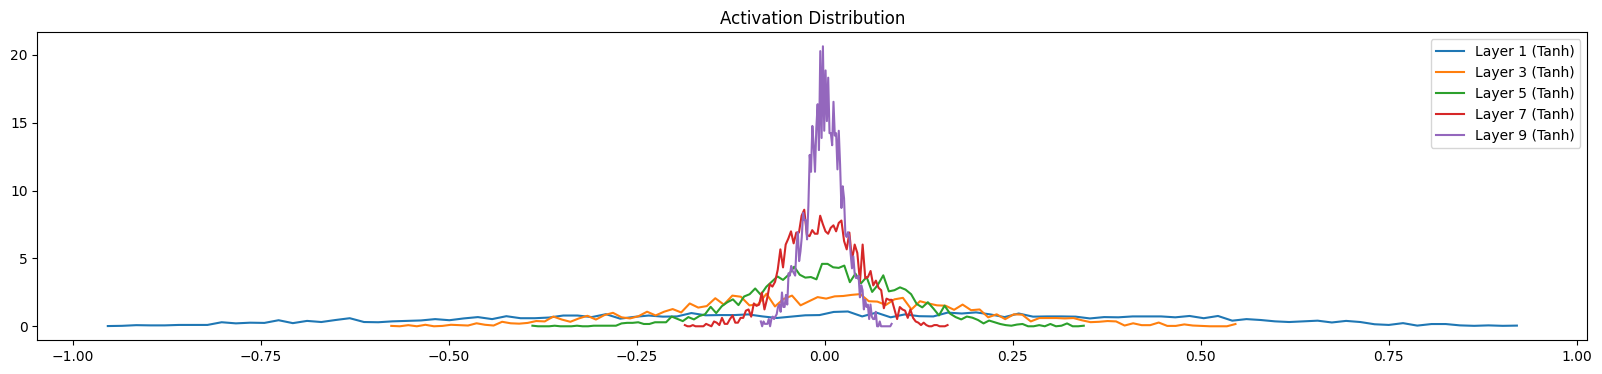

In [169]:
visualize_activations_or_gradients(layers)

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


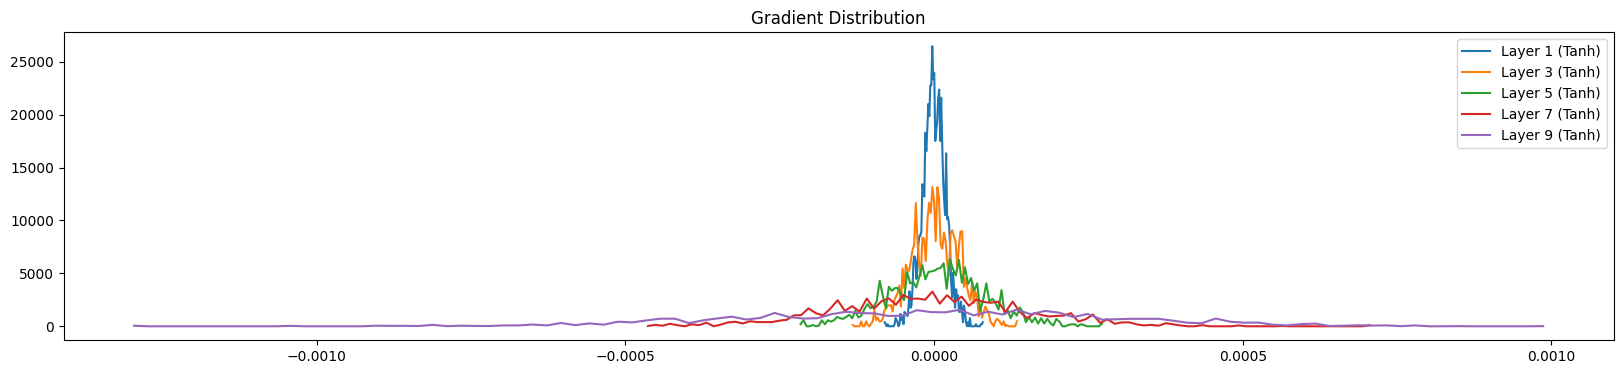

In [170]:
visualize_activations_or_gradients(layers, show_activations=False)

In [171]:
C, layers, parameters = create_model(gain=1)
train_model_with_brake(C, layers, parameters, 1)

46497
      0/ 200000: 3.2913


layer 1 (      Tanh): mean +0.00, std 0.64, saturated: 5.16%
layer 3 (      Tanh): mean -0.04, std 0.49, saturated: 0.06%
layer 5 (      Tanh): mean -0.01, std 0.41, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.37, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.32, saturated: 0.00%


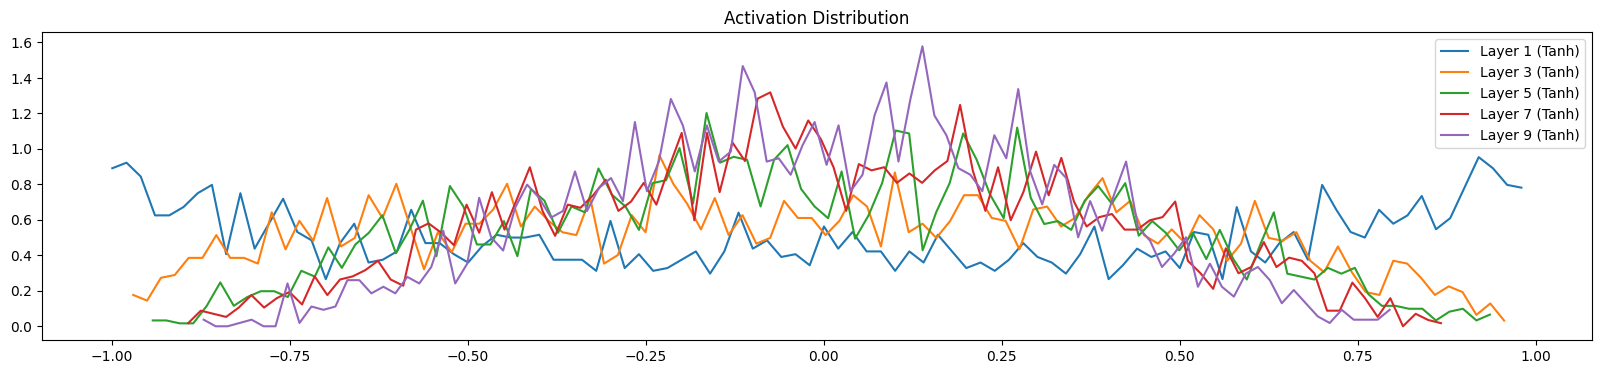

In [172]:
visualize_activations_or_gradients(layers)

layer 1 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


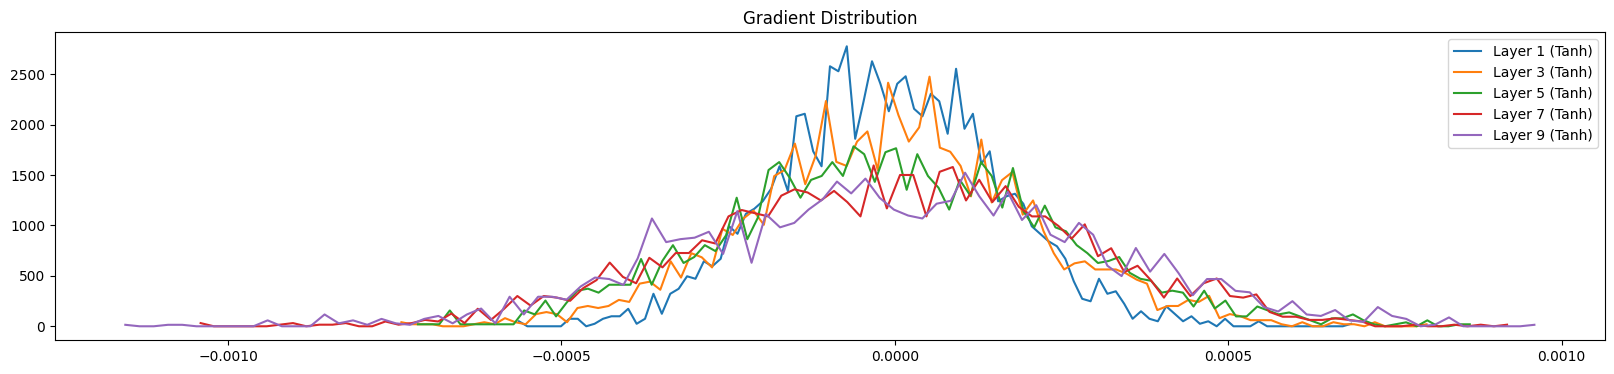

In [173]:
visualize_activations_or_gradients(layers, show_activations=False)

In [174]:
C, layers, parameters = create_model(gain=0.5)
train_model_with_brake(C, layers, parameters, 1)

46497
      0/ 200000: 3.2963


layer 1 (      Tanh): mean -0.02, std 0.42, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.21, saturated: 0.00%
layer 5 (      Tanh): mean +0.01, std 0.11, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.05, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.02, saturated: 0.00%


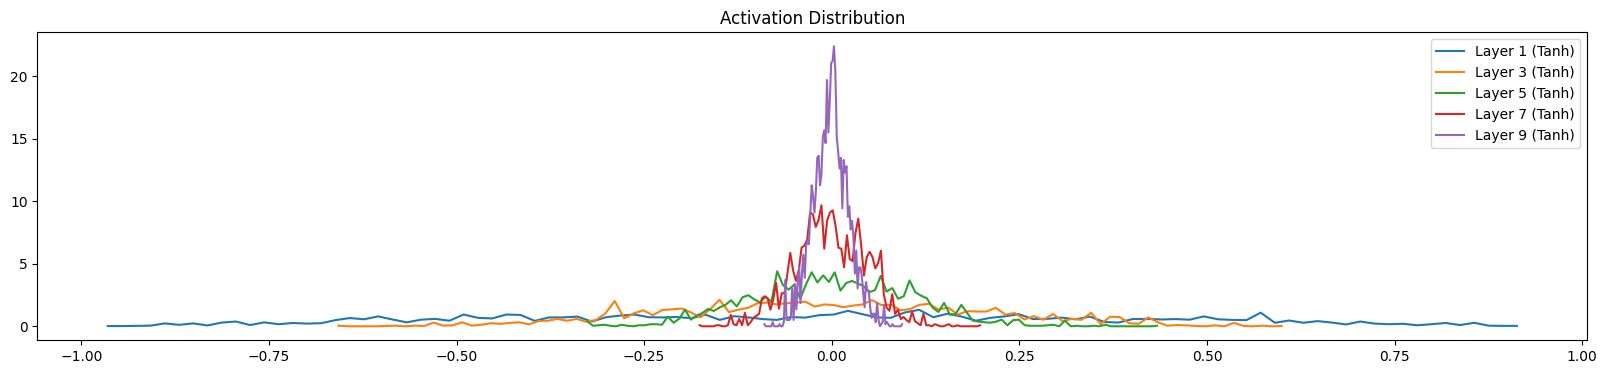

In [175]:
visualize_activations_or_gradients(layers)

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


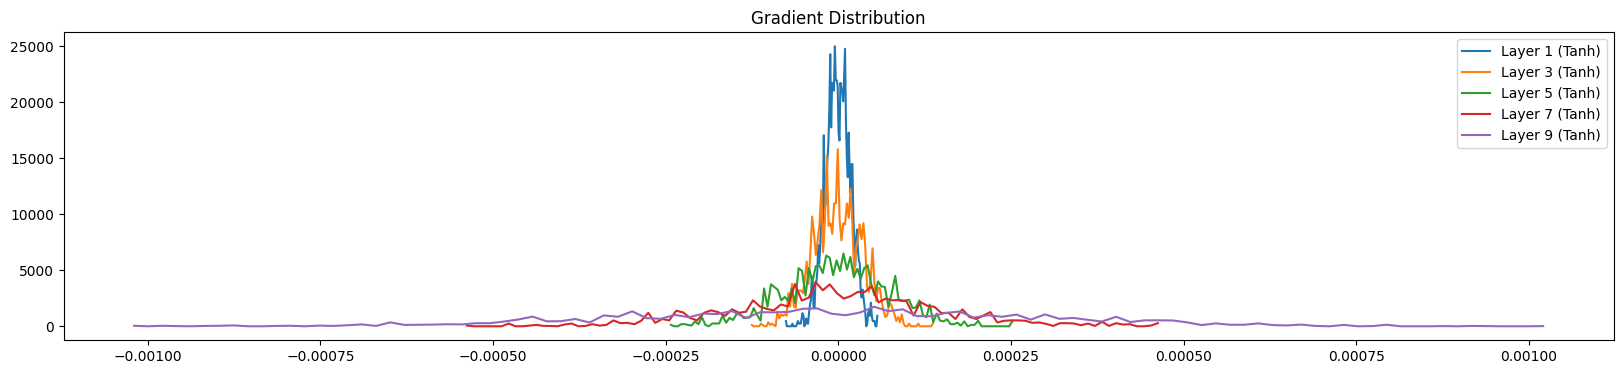

In [176]:
visualize_activations_or_gradients(layers, show_activations=False)

In [196]:
C, layers, parameters = create_model(gain=5/3)
ud = train_model_with_brake(C, layers, parameters, 1000)

46497
      0/ 200000: 3.2846


layer 1 (      Tanh): mean +0.02, std 0.76, saturated: 20.91%
layer 3 (      Tanh): mean -0.04, std 0.72, saturated: 12.38%
layer 5 (      Tanh): mean +0.01, std 0.72, saturated: 11.81%
layer 7 (      Tanh): mean +0.00, std 0.72, saturated: 12.38%
layer 9 (      Tanh): mean +0.02, std 0.74, saturated: 12.69%


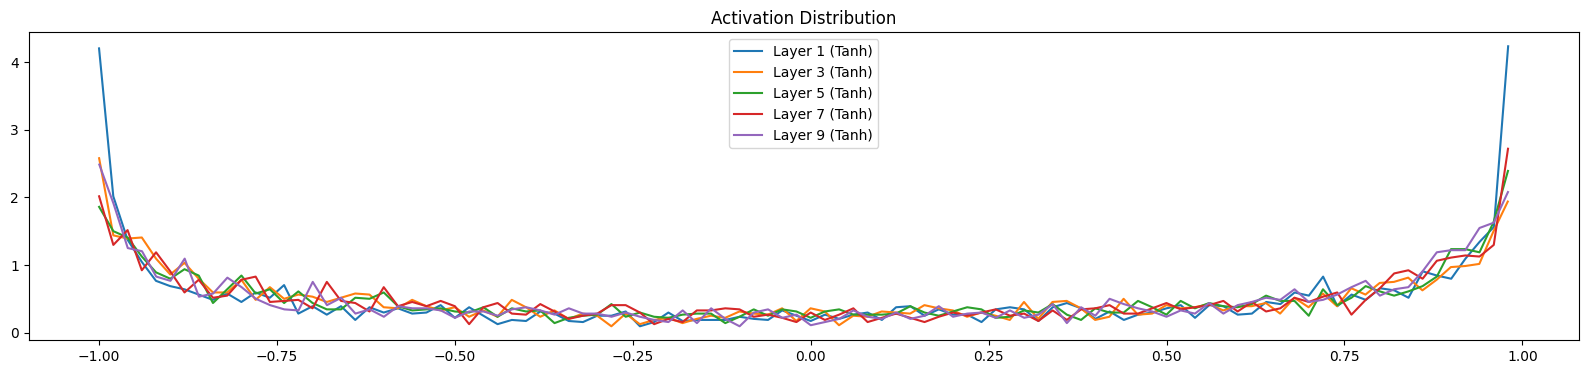

In [197]:
visualize_activations_or_gradients(layers)

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


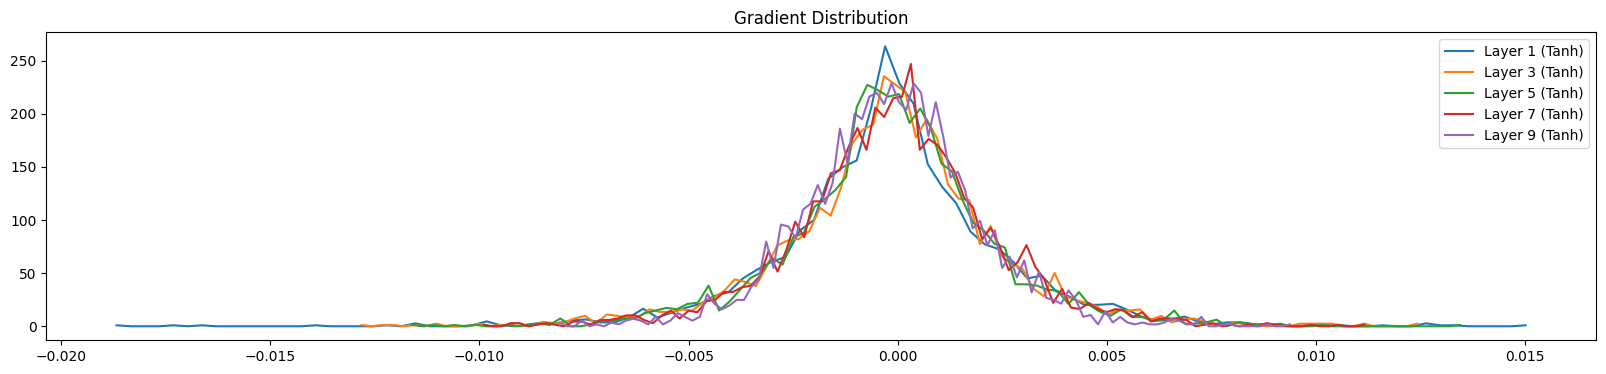

In [198]:
visualize_activations_or_gradients(layers, show_activations=False)

In [199]:
def visualize_update_to_data_ratio(ud):
  # Update to Data Ratio Histogram (below is what it looks like ideally)
  plt.figure(figsize=(20, 4))
  legends = []
  for i,p in enumerate(parameters):
    if p.ndim == 2:
      plt.plot([ud[j][i] for j in range(len(ud))])
      legends.append('param %d' % i)
  plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
  plt.legend(legends);

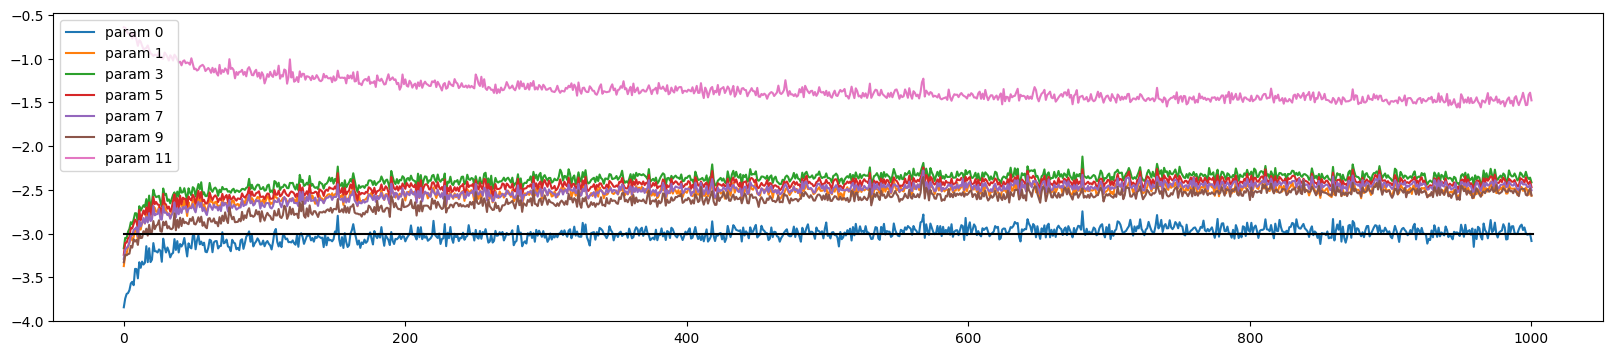

In [200]:
visualize_update_to_data_ratio(ud)

### Now with Batchnorm

In [187]:
def create_model_bn():
    n_embd = 10
    n_hidden = 100
    g = torch.Generator().manual_seed(2147483647)

    C = torch.randn((vocab_size, n_embd), generator=g)

    layers = [
        Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
    ]

    with torch.no_grad():
        layers[-1].gamma *= 0.1
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 1.0

    parameters = [C] + [p for layer in layers for p in layer.parameters()]
    print(sum(p.nelement() for p in parameters))

    for p in parameters:
        p.requires_grad = True
    
    return C, layers, parameters

In [188]:
C, layers, parameters = create_model_bn()
ud = train_model_with_brake(C, layers, parameters, 1000)

47551
      0/ 200000: 3.2889


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 2.53%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.72%
layer 8 (      Tanh): mean +0.01, std 0.64, saturated: 2.34%
layer 11 (      Tanh): mean -0.01, std 0.65, saturated: 1.88%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.72%


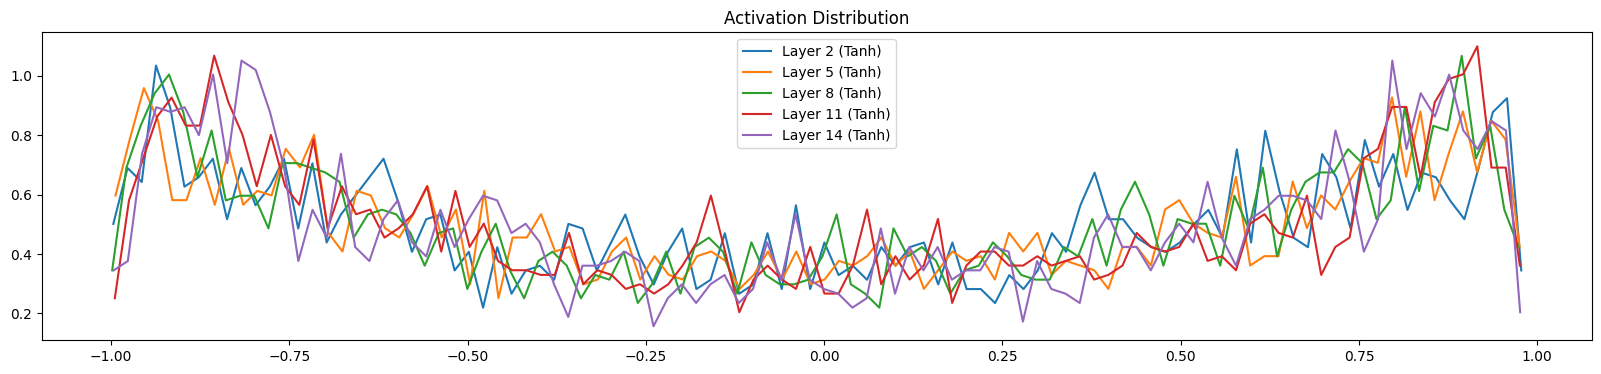

In [189]:
visualize_activations_or_gradients(layers)

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


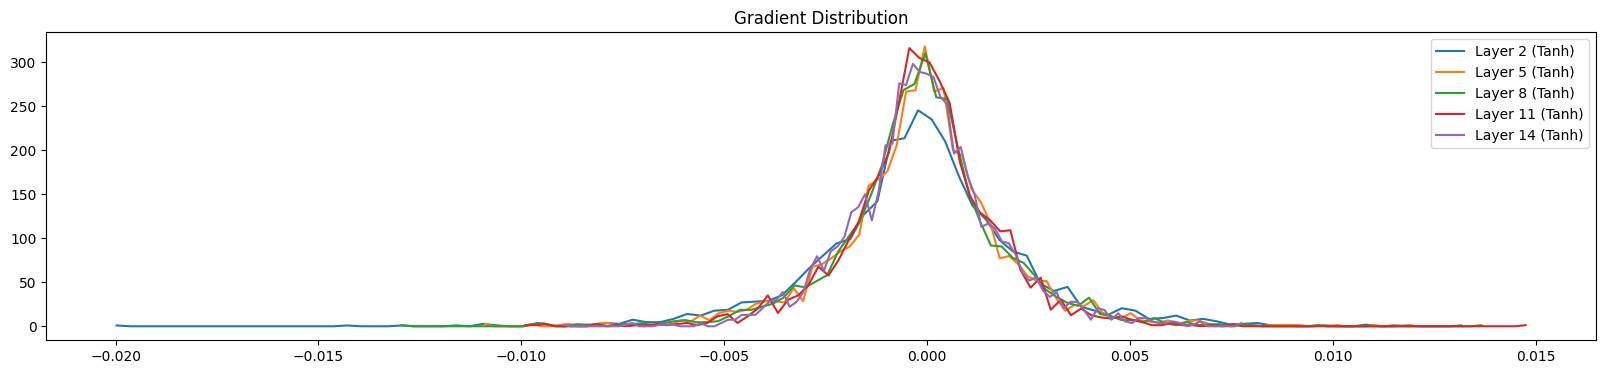

In [190]:
visualize_activations_or_gradients(layers, show_activations=False)

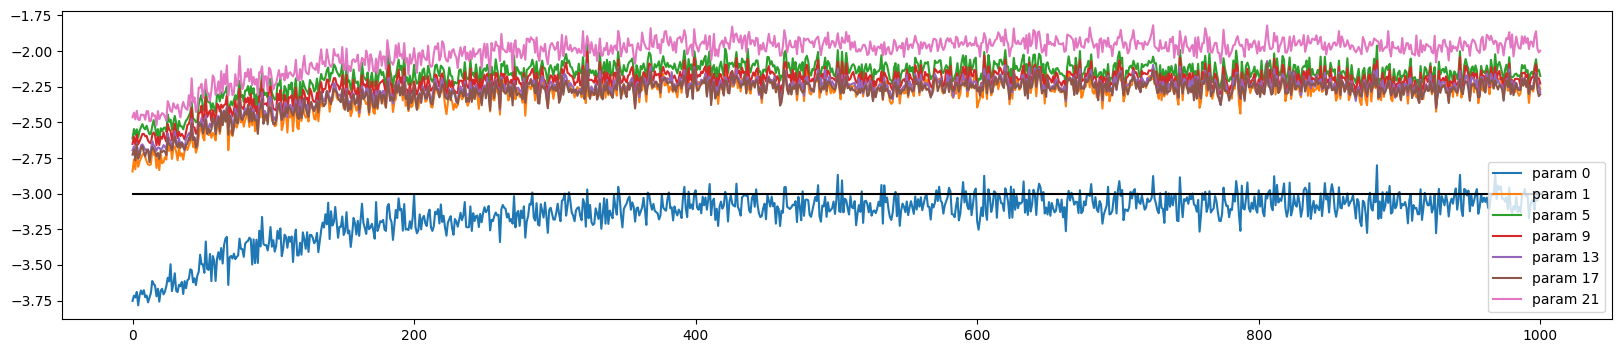

In [193]:
visualize_update_to_data_ratio(ud)

## Exercises

In [27]:
# set the weights and biases to zero
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.0 # 10 values x 3 priors x 200 neur.
b1 = torch.randn(n_hidden,                        generator=g) * 0.0# 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.0 # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size,                      generator=g) * 0.0 # 27 output biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True

11897 parameters


In [28]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)          
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    h.retain_grad()
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    break # run only the first batch

      0/ 200000: 3.2958


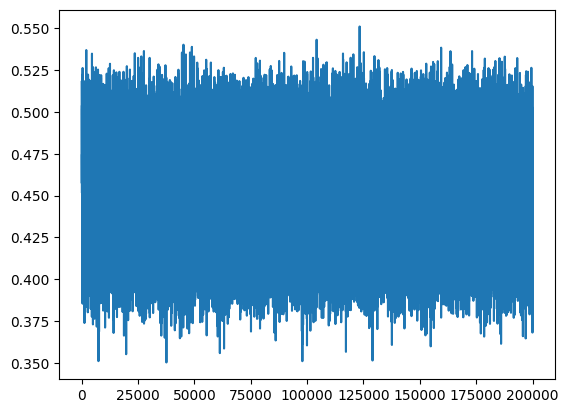

In [207]:
plt.plot(lossi)

In [ ]:
def visualize_activations_or_gradients(layers, show_activations: bool = True):
    # Visualize histograms (forward pass activations) for the Tanh layers
    # (below is what it looks like when Batch-Normalization is needed)
    # We can see how many tensor values take on which x-axis values
    plt.figure(figsize=(20, 4)) # Width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer, these are all Tanh layers
        if isinstance(layer, Tanh):
            if show_activations:
                t = layer.out
            else:
                t = layer.out.grad
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'Layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
    if show_activations:
        plt.title('Activation Distribution')
    else:
        plt.title('Gradient Distribution')

In [21]:
h.shape

torch.Size([32, 200])

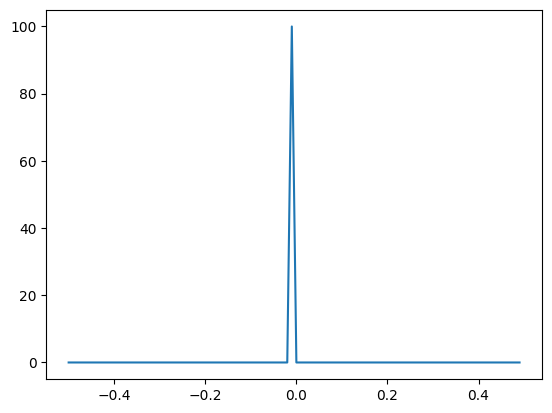

In [29]:
# analyze the actications of h
hy, hx = torch.histogram(h, density=True)
plt.plot(hx[:-1].detach(), hy.detach())

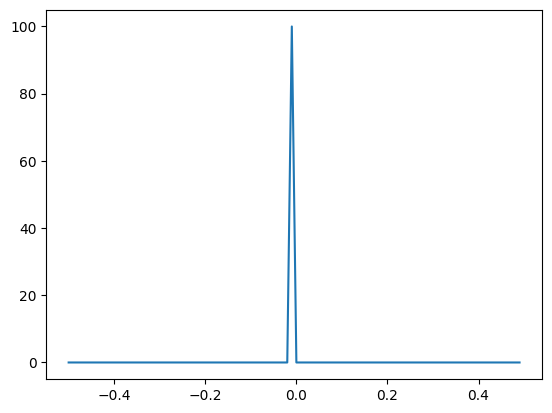

In [31]:
# analyze the gradients of h
hy, hx = torch.histogram(h.grad, density=True)
plt.plot(hx[:-1].detach(), hy.detach())

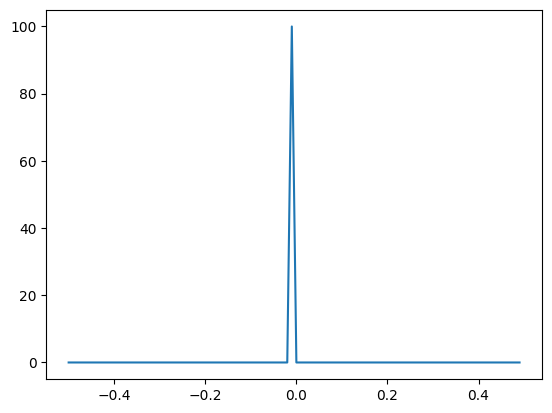

In [32]:
# analyze the pre-actications of h
hy, hx = torch.histogram(hpreact, density=True)
plt.plot(hx[:-1].detach(), hy.detach())

In [33]:
torch.tanh(torch.tensor(0))

tensor(0.)

In [35]:
dh = 0.0001
(torch.tanh(torch.tensor(0 + dh)) - torch.tanh(torch.tensor(0))) / dh

tensor(1.)